# Loading Packages

In [14]:
#Load the packages
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
from shapely import wkb 

In [15]:
#install libraries
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [16]:
#DB CONNECTION

import psycopg2
from psycopg2 import sql
from psycopg2.extensions import adapt, register_adapter, AsIs
from sqlalchemy import create_engine,text
import getpass
import re
from sklearn.preprocessing import normalize

In [17]:
#install libraries
%pip install rtree

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#DB connection string
database = 'f24t03'
user = 'jsmm8'
mypasswd = getpass.getpass("Type password and hit enter: ")

Type password and hit enter: ········


# Loading Geospatial Data

In [19]:
# Laod neighborhood service areas geodb into table
gdb_path = 'nsa.gdb'

#check the layers in the geodatabase
layers = gpd.io.file.fiona.listlayers(gdb_path)
print("Layers found in GDB:", layers)

# Load 
nsa = gpd.read_file(gdb_path, layer=layers[0])

# Reproject to EPSG:26915
nsa = nsa.to_crs(epsg=26915)

# preview
nsa.head()


Layers found in GDB: ['springfield__neighborhood_service_areas']


,OBJECTID_1,NAME,ShapeSTAre,ShapeSTLen,Shape_Length,Shape_Area,geometry
0,1.0,Grant Beach,3.107893e+07,22403.823703,6826.057182,2.885105e+06,"MULTIPOLYGON (((474089.118 4120469.519, 474088..."
1,2.0,Oak Grove,5.694040e+07,32119.505522,9786.311928,5.285924e+06,"MULTIPOLYGON (((480052.310 4114905.475, 480052..."
2,3.0,Midtown,2.839690e+07,21373.071458,6512.016504,2.636137e+06,"MULTIPOLYGON (((475419.924 4118741.896, 475052..."
3,4.0,Weller,2.558836e+07,20759.618765,6325.117077,2.375422e+06,"MULTIPOLYGON (((476778.203 4118815.866, 476776..."
4,5.0,Woodland Heights,2.922756e+07,23012.009407,7011.363483,2.713241e+06,"MULTIPOLYGON (((472934.565 4120381.619, 472883..."


In [ ]:
# Convert geometry to WKT for SQL insertion
nsa['geom_wkt'] = nsa['geometry'].apply(lambda x: x.wkt)

database = "f24t03"
user = "jsmm8"
host = "pgsql"
engine = create_engine(f'postgresql+psycopg2://{user}:{mypasswd}@{host}/{database}')
conn = psycopg2.connect(database=database, user=user, host=host, password=mypasswd)
cursor = conn.cursor()

#Drop Table If Exists and Create New Table
table_name = "springfield_neighborhood_service_areas"

create_table_sql = f"""
DROP TABLE IF EXISTS {table_name};

CREATE TABLE {table_name} (
    objectid_1 INTEGER,
    name TEXT,
    shapestare DOUBLE PRECISION,
    shapestlen DOUBLE PRECISION,
    shape_length DOUBLE PRECISION,
    shape_area DOUBLE PRECISION,
    geom GEOMETRY(MULTIPOLYGON, 26915)
);
"""
cursor.execute(create_table_sql)
conn.commit()
print(f"Table `{table_name}` created successfully.")

# Insert Data into PostGIS Table 
insert_sql = text(f"""
    INSERT INTO {table_name} (
        objectid_1, name, shapestare, shapestlen, shape_length, shape_area, geom
    ) VALUES (
        :objectid_1, :name, :shapestare, :shapestlen, :shape_length, :shape_area,
        ST_Multi(ST_GeomFromText(:geom_wkt, 26915))
    );
""")

# Insert in chunks 
chunk_size = 100
for start in range(0, len(nsa), chunk_size):
    chunk = nsa.iloc[start:start + chunk_size]
    with engine.begin() as connection:
        for _, row in chunk.iterrows():
            connection.execute(insert_sql, {
                'objectid_1': int(row['OBJECTID_1']) if pd.notnull(row['OBJECTID_1']) else None,
                'name': row['NAME'],
                'shapestare': row['ShapeSTAre'],
                'shapestlen': row['ShapeSTLen'],
                'shape_length': row['Shape_Length'],
                'shape_area': row['Shape_Area'],
                'geom_wkt': row['geom_wkt']
            })
    print(f"Inserted chunk of {len(chunk)} records.")

print("All data inserted into PostGIS table successfully.")

# Cleanup 
cursor.close()
conn.close()

Table `springfield_neighborhood_service_areas` created successfully.
Inserted chunk of 38 records.
All data inserted into PostGIS table successfully.


In [ ]:
#Create the connection and extract data from 'springfield_neighborhood_service_areas' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the springfield_neighborhood_service_areas table
query = "SELECT * FROM springfield_neighborhood_service_areas;"

try:
    nsa = gpd.read_postgis(query, conn, geom_col='geom')
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()

# Display the DataFrame
print(nsa.shape)
#sample 
nsa.head()

I am able to connect to the database
Data extracted successfully!
(38, 7)


,objectid_1,name,shapestare,shapestlen,shape_length,shape_area,geom
0,1,Grant Beach,3.107893e+07,22403.823703,6826.057182,2.885105e+06,"MULTIPOLYGON (((474089.118 4120469.519, 474088..."
1,2,Oak Grove,5.694040e+07,32119.505522,9786.311928,5.285924e+06,"MULTIPOLYGON (((480052.310 4114905.475, 480052..."
2,3,Midtown,2.839690e+07,21373.071458,6512.016504,2.636137e+06,"MULTIPOLYGON (((475419.924 4118741.896, 475052..."
3,4,Weller,2.558836e+07,20759.618765,6325.117077,2.375422e+06,"MULTIPOLYGON (((476778.203 4118815.866, 476776..."
4,5,Woodland Heights,2.922756e+07,23012.009407,7011.363483,2.713241e+06,"MULTIPOLYGON (((472934.565 4120381.619, 472883..."


In [23]:
# load parcels Geodatabase
gdb_path = 'parcels.gdb'

# List  layers
layers = gpd.io.file.fiona.listlayers(gdb_path)
print("Layers found in GDB:", layers)

# Load  layer
df_parcel_boundary = gpd.read_file(gdb_path, layer=layers[0])

# Reproject to EPSG:26915 
df_parcel_boundary = df_parcel_boundary.to_crs(epsg=26915)

# Preview
df_parcel_boundary.head()


Layers found in GDB: ['base_try']


,OBJECTID_1,OBJECTID,PRIM_NUM,SUB_NUM,PRE_DIR,STR_NAM,STR_TYPE,CITY,STATE,ZIP5,ADDRESS,BLOCK,NSA,BDS_ZONE,ZONING,PD_NUM,Shape_Leng,Shape_Area,geometry
0,1.0,99934.0,9667,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,9667 E FR194,9600,N/A,N/A,N/A,0.0,458.692989,11367.548951,"MULTIPOLYGON (((492569.645 4104829.199, 492568..."
1,2.0,99944.0,6569,None,S,STATE HIGHWAY VV,None,ROGERSVILLE,MO,65742,6569 S SHVV,6500,N/A,N/A,N/A,0.0,999.022143,42067.376655,"MULTIPOLYGON (((493778.447 4104828.408, 493776..."
2,3.0,113935.0,9415,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,9415 E FR194,9400,N/A,N/A,N/A,0.0,565.027466,18883.626111,"MULTIPOLYGON (((492073.243 4104875.064, 492071..."
3,4.0,113944.0,8703,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,8703 E FR194,8700,N/A,N/A,N/A,0.0,1119.587973,39530.717156,"MULTIPOLYGON (((490701.506 4104889.623, 490956..."
4,5.0,95584.0,8133,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,8133 E FR194,8100,N/A,N/A,N/A,0.0,530.007469,13331.032735,"MULTIPOLYGON (((489542.191 4104913.918, 489540..."


In [ ]:
# Add WKT Geometry for conversion
df_parcel_boundary['geom_wkt'] = df_parcel_boundary['geometry'].apply(lambda x: x.wkt)


database = "f24t03"
user = "jsmm8"
host = "pgsql"
engine = create_engine(f'postgresql+psycopg2://{user}:{mypasswd}@{host}/{database}')
conn = psycopg2.connect(database=database, user=user, host=host, password=mypasswd)
cursor = conn.cursor()

table_name = "parcel_boundaries"

# table with column names in df_parcel_boundary
create_table_sql = f"""
DROP TABLE IF EXISTS {table_name};

CREATE TABLE {table_name} (
    objectid_1 INTEGER,
    objectid INTEGER,
    prim_num TEXT,
    sub_num TEXT,
    pre_dir TEXT,
    str_nam TEXT,
    str_type TEXT,
    city TEXT,
    state TEXT,
    zip5 TEXT,
    address TEXT,
    block TEXT,
    nsa TEXT,
    bds_zone TEXT,
    zoning TEXT,
    pd_num TEXT,
    shape_leng DOUBLE PRECISION,
    shape_area DOUBLE PRECISION,
    geom GEOMETRY(MULTIPOLYGON, 26915)
);
"""
cursor.execute(create_table_sql)
conn.commit()
print(f"Table `{table_name}` created successfully.")

#  Insert Data into PostGIS Table 
insert_sql = text(f"""
    INSERT INTO {table_name} (
        objectid_1, objectid, prim_num, sub_num, pre_dir, str_nam, str_type, city,
        state, zip5, address, block, nsa, bds_zone, zoning, pd_num,
        shape_leng, shape_area, geom
    ) VALUES (
        :objectid_1, :objectid, :prim_num, :sub_num, :pre_dir, :str_nam, :str_type, :city,
        :state, :zip5, :address, :block, :nsa, :bds_zone, :zoning, :pd_num,
        :shape_leng, :shape_area,
        ST_Multi(ST_GeomFromText(:geom_wkt, 26915))
    );
""")

# Insert Data in Chunks 
chunk_size = 500
for start in range(0, len(df_parcel_boundary), chunk_size):
    chunk = df_parcel_boundary.iloc[start:start + chunk_size]
    with engine.begin() as connection:
        for _, row in chunk.iterrows():
            connection.execute(insert_sql, {
                'objectid_1': int(row['OBJECTID_1']) if pd.notnull(row['OBJECTID_1']) else None,
                'objectid': int(row['OBJECTID']) if pd.notnull(row['OBJECTID']) else None,
                'prim_num': row['PRIM_NUM'],
                'sub_num': row['SUB_NUM'],
                'pre_dir': row['PRE_DIR'],
                'str_nam': row['STR_NAM'],
                'str_type': row['STR_TYPE'],
                'city': row['CITY'],
                'state': row['STATE'],
                'zip5': row['ZIP5'],
                'address': row['ADDRESS'],
                'block': row['BLOCK'],
                'nsa': row['NSA'],
                'bds_zone': row['BDS_ZONE'],
                'zoning': row['ZONING'],
                'pd_num': row['PD_NUM'],
                'shape_leng': row['Shape_Leng'],
                'shape_area': row['Shape_Area'],
                'geom_wkt': row['geom_wkt']
            })
    

# Cleanup 
cursor.close()
conn.close()
print("All parcel data inserted into PostGIS table successfully.")


Table `parcel_boundaries` created successfully.
All parcel data inserted into PostGIS table successfully.


In [ ]:
#Create the connection and extract data from 'parcel_boundaries' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the parcel_boundaries table
query = "SELECT * FROM parcel_boundaries;"

try:
    gdf_parcel_boundary = gpd.read_postgis(query, conn, geom_col='geom')
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
print(gdf_parcel_boundary.shape)
#sample
gdf_parcel_boundary.head()




I am able to connect to the database
Data extracted successfully!
(157634, 19)


,objectid_1,objectid,prim_num,sub_num,pre_dir,str_nam,str_type,city,state,zip5,address,block,nsa,bds_zone,zoning,pd_num,shape_leng,shape_area,geom
0,1,99934,9667,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,9667 E FR194,9600,N/A,N/A,N/A,0.0,458.692989,11367.548951,"MULTIPOLYGON (((492569.645 4104829.199, 492568..."
1,2,99944,6569,None,S,STATE HIGHWAY VV,None,ROGERSVILLE,MO,65742,6569 S SHVV,6500,N/A,N/A,N/A,0.0,999.022143,42067.376655,"MULTIPOLYGON (((493778.447 4104828.408, 493776..."
2,3,113935,9415,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,9415 E FR194,9400,N/A,N/A,N/A,0.0,565.027466,18883.626111,"MULTIPOLYGON (((492073.243 4104875.064, 492071..."
3,4,113944,8703,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,8703 E FR194,8700,N/A,N/A,N/A,0.0,1119.587973,39530.717156,"MULTIPOLYGON (((490701.506 4104889.623, 490956..."
4,5,95584,8133,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,8133 E FR194,8100,N/A,N/A,N/A,0.0,530.007469,13331.032735,"MULTIPOLYGON (((489542.191 4104913.918, 489540..."


In [ ]:
#Create the connection and extract data from 'distance_drive_times' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the distance_drive_times table
query = "SELECT * FROM distance_drive_times;"

try:
    df = gpd.read_postgis(query, conn, geom_col='home_geolocation')
    print("Data extracted successfully!")
    # Find and convert other geometry columns containing '_geolocation_'
    geo_cols = [col for col in df.columns if '_geolocation_' in col and col != 'home_geolocation']

    for col in geo_cols:
        df[col] = df[col].apply(lambda x: (
            wkb.loads(x, hex=True) if isinstance(x, str) else
            wkb.loads(bytes(x)) if x else None
        ))

    print(f"Converted geometry columns: {geo_cols}")

except Exception as e:
    print("Error extracting data:", e)

finally:
    if conn:
        conn.close()
        print("Database connection closed.")

# Display DataFrame only if extraction succeeded
if df is not None:
    print("DataFrame shape:", df.shape)
else:
    print("No data to display.")




I am able to connect to the database
Data extracted successfully!
Converted geometry columns: ['feature_geolocation_fire', 'feature_geolocation_police', 'feature_geolocation_early_childhood_school', 'feature_geolocation_elementary_school', 'feature_geolocation_middle_school', 'feature_geolocation_high_school', 'feature_geolocation_hospital', 'feature_geolocation_nursing_home', 'feature_geolocation_public_health', 'feature_geolocation_urgentcare', 'feature_geolocation_trailheads']
Database connection closed.
DataFrame shape: (43445, 58)


In [29]:
#check columns list
df.columns

Index(['home_geolocation', 'address', 'zip5', 'drive_time_fire',
       'drive_distance_fire', 'feature_geolocation_fire',
       'feature_address_fire', 'feature_category_fire', 'drive_time_police',
       'drive_distance_police', 'feature_geolocation_police',
       'feature_address_police', 'feature_category_police',
       'drive_time_early_childhood_school',
       'drive_distance_early_childhood_school',
       'feature_geolocation_early_childhood_school',
       'feature_address_early_childhood_school',
       'feature_category_early_childhood_school',
       'drive_time_elementary_school', 'drive_distance_elementary_school',
       'feature_geolocation_elementary_school',
       'feature_address_elementary_school',
       'feature_category_elementary_school', 'drive_time_middle_school',
       'drive_distance_middle_school', 'feature_geolocation_middle_school',
       'feature_address_middle_school', 'feature_category_middle_school',
       'drive_time_high_school', 'drive_dist

In [30]:
#check shape
df.shape

(43445, 58)

In [31]:
#check sample
df.head()

,home_geolocation,address,zip5,drive_time_fire,drive_distance_fire,feature_geolocation_fire,feature_address_fire,feature_category_fire,drive_time_police,drive_distance_police,...,drive_time_urgentcare,drive_distance_urgentcare,feature_geolocation_urgentcare,feature_address_urgentcare,feature_category_urgentcare,drive_time_trailheads,drive_distance_trailheads,feature_geolocation_trailheads,feature_address_trailheads,feature_category_trailheads
0,POINT (479731.157 4105446.197),6525 S MEADOWVIEW AVE,65721,4.19,1.6,POINT (477459.2576485137 4106497.905080578),2251 E FR188,BATTLEFIELD STA 2,14.4,8.33,...,12.06,6.82,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.93,2.09,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
1,POINT (479701.523 4105456.647),6519 S MEADOWVIEW AVE,65721,4.19,1.6,POINT (477459.2576485137 4106497.905080578),2251 E FR188,BATTLEFIELD STA 2,14.4,8.33,...,12.06,6.82,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.93,2.09,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
2,POINT (479759.341 4105462.900),6520 S MEADOWVIEW AVE,65721,4.19,1.6,POINT (477459.2576485137 4106497.905080578),2251 E FR188,BATTLEFIELD STA 2,14.4,8.33,...,12.06,6.82,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.93,2.09,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
3,POINT (479700.770 4105489.946),6513 S MEADOWVIEW AVE,65721,4.19,1.6,POINT (477459.2576485137 4106497.905080578),2251 E FR188,BATTLEFIELD STA 2,14.4,8.33,...,12.06,6.82,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.93,2.09,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
4,POINT (479765.582 4105489.618),6512 S MEADOWVIEW AVE,65721,4.19,1.6,POINT (477459.2576485137 4106497.905080578),2251 E FR188,BATTLEFIELD STA 2,14.4,8.33,...,12.06,6.82,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.93,2.09,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None


In [32]:
#see info for column structure
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43445 entries, 0 to 43444
Data columns (total 58 columns):
home_geolocation                              43445 non-null geometry
address                                       43445 non-null object
zip5                                          43445 non-null object
drive_time_fire                               43433 non-null float64
drive_distance_fire                           43433 non-null float64
feature_geolocation_fire                      43433 non-null object
feature_address_fire                          43433 non-null object
feature_category_fire                         43433 non-null object
drive_time_police                             43433 non-null float64
drive_distance_police                         43433 non-null float64
feature_geolocation_police                    43433 non-null object
feature_address_police                        43433 non-null object
feature_category_police                       43433 non-null 

# Data Shaping & Carpentry

In [34]:
#https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-missouri-block-group -->Downloaded shapefile from website

# Load the shapefile into a GeoDataFrame with MO block groups
gdf_map = gpd.read_file('tl_2023_29_bg.shp')


# Filter the data to only include rows where COUNTYFP is '077' for GREENE county
gdf_filtered = gdf_map[gdf_map['COUNTYFP'].isin(['077'])]



In [35]:
#Check crs
gdf_filtered.crs

{'init': 'epsg:4269'}

In [36]:
# Convert to EPSG:26915
gdf_filtered = gdf_filtered.to_crs('EPSG:26915')

In [37]:
#validate crs
gdf_filtered.crs

'EPSG:26915'

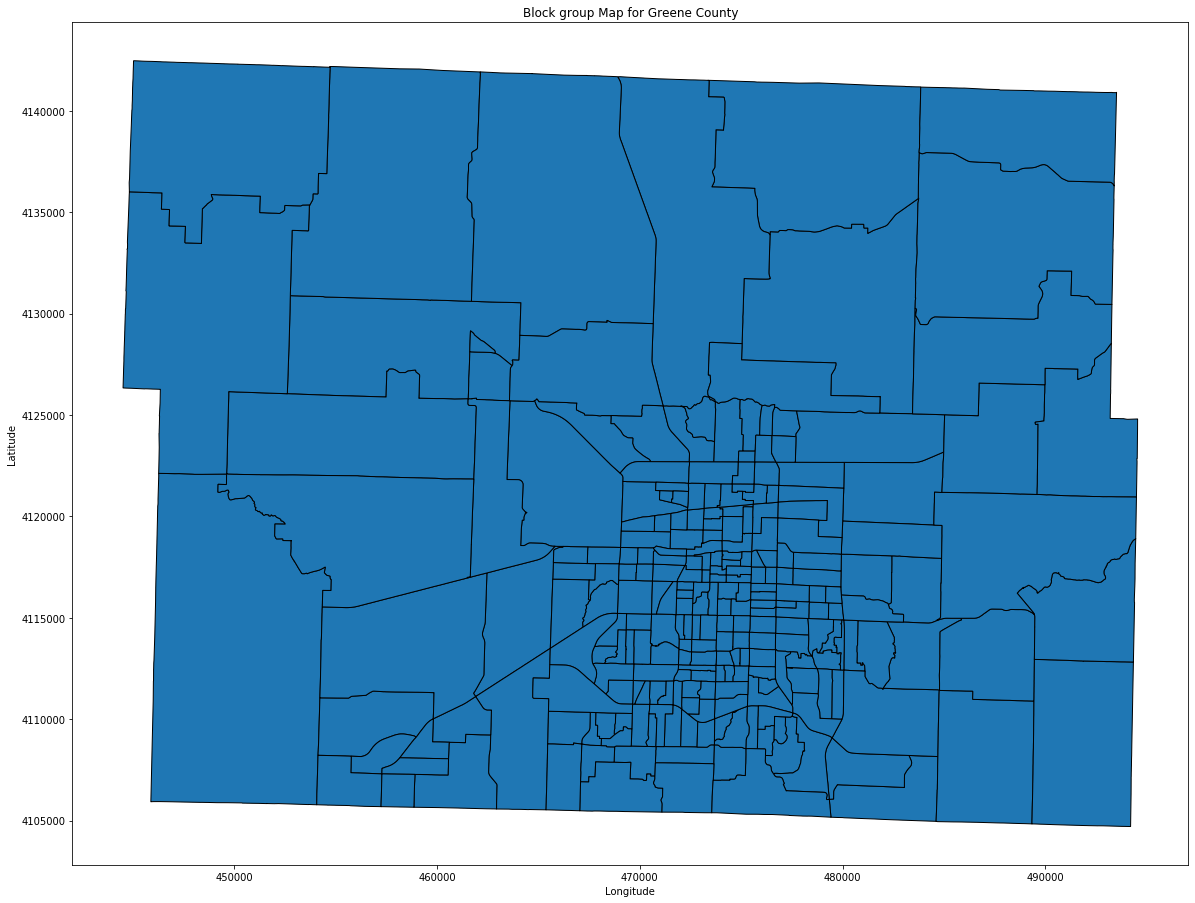

In [38]:
# Plot the filtered data
gdf_filtered.plot(figsize=(20, 20), edgecolor='black')

plt.title('Block group Map for Greene County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)

# Show the plot
plt.show()

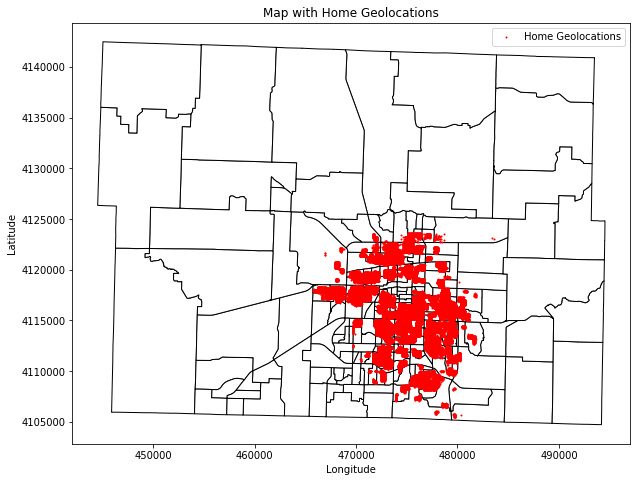

In [39]:
# make 'home_geolocation' is in Point format and set it as a geometry column
df['home_geolocation'] = gpd.GeoSeries(df['home_geolocation'])

# Set the geometry of df to the home_geolocation column
df.set_geometry('home_geolocation', inplace=True)

# Plot the filtered gdf
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
gdf_filtered.plot(ax=ax,color='white', edgecolor='black')

# Overlay the home_geolocation points on the same map
df.plot(ax=ax, marker='o', color='red', markersize=1, label='Home Geolocations')

ax.legend()

# Title and labels
plt.title('Map with Home Geolocations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


In [40]:
#check sample
gdf_filtered.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
5,29,077,003801,1,290770038011,1500000US290770038011,Block Group 1,G5030,S,10722109,0,+37.1019246,-093.1972666,"POLYGON ((479343.875 4106052.080, 479361.739 4..."
6,29,077,005801,2,290770058012,1500000US290770058012,Block Group 2,G5030,S,986621,0,+37.1791420,-093.3385136,"POLYGON ((469327.252 4114507.160, 469328.273 4..."
115,29,077,004105,2,290770041052,1500000US290770041052,Block Group 2,G5030,S,832329,0,+37.1295987,-093.3640843,"POLYGON ((467137.699 4108793.665, 467139.600 4..."
116,29,077,001500,5,290770015005,1500000US290770015005,Block Group 5,G5030,S,353581,0,+37.1689432,-093.3125017,"POLYGON ((471924.200 4113477.355, 471924.886 4..."
117,29,077,005802,3,290770058023,1500000US290770058023,Block Group 3,G5030,S,2745031,0,+37.1901492,-093.3406738,"POLYGON ((468898.044 4115228.395, 468898.530 4..."


In [41]:
#check the blockgroups in GREENE county dataframe
gdf_filtered.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 242 entries, 5 to 4924
Data columns (total 14 columns):
STATEFP     242 non-null object
COUNTYFP    242 non-null object
TRACTCE     242 non-null object
BLKGRPCE    242 non-null object
GEOID       242 non-null object
GEOIDFQ     242 non-null object
NAMELSAD    242 non-null object
MTFCC       242 non-null object
FUNCSTAT    242 non-null object
ALAND       242 non-null int64
AWATER      242 non-null int64
INTPTLAT    242 non-null object
INTPTLON    242 non-null object
geometry    242 non-null geometry
dtypes: geometry(1), int64(2), object(11)
memory usage: 28.4+ KB


In [42]:
# Check for invalid geometries in df
invalid_gdf = df[~df['home_geolocation'].is_valid]
print(f"Invalid geometries in df: {len(invalid_gdf)}")

# Check for invalid geometries in gdf_filtered
invalid_gdf_filtered = gdf_filtered[~gdf_filtered['geometry'].is_valid]
print(f"Invalid geometries in gdf_filtered: {len(invalid_gdf_filtered)}")


Invalid geometries in df: 0
Invalid geometries in gdf_filtered: 0


In [43]:
# Create an empty list to store the data
extracted_data = []

# Iterate over the geolocations (points in df) and extract block group id values
for idx, row in df.iterrows():
    point = row['home_geolocation']
    address = row['address']  # Extract the address from the df
    
    # Find the corresponding block group in gdf_filtered by checking if the point is within any polygon
    matching_rows = gdf_filtered[gdf_filtered['geometry'].contains(point)]  # Check if point is within block group
    
    if not matching_rows.empty:
        # If a match is found, get the block group id value from gdf_filtered
        geo_id = matching_rows.iloc[0]['GEOIDFQ']
        
        # Append the data (point, GEOIDFQ,address and geometry) to the list
        extracted_data.append({
            'Point': point,
            'GEOIDFQ': geo_id,
            'geometry': matching_rows.iloc[0]['geometry'],  # Add the geometry from the matched block group
            'address': address  # Add the address from df  
        })

# Convert the list of data to a DataFrame
extracted_df = pd.DataFrame(extracted_data)


In [44]:
#check sample
extracted_df.head()

,Point,GEOIDFQ,geometry,address
0,POINT (479731.1567271573 4105446.196936952),1500000US290770038011,"POLYGON ((479343.8751168707 4106052.08007338, ...",6525 S MEADOWVIEW AVE
1,POINT (479701.5227639587 4105456.646765461),1500000US290770038011,"POLYGON ((479343.8751168707 4106052.08007338, ...",6519 S MEADOWVIEW AVE
2,POINT (479759.3414113432 4105462.899646826),1500000US290770038011,"POLYGON ((479343.8751168707 4106052.08007338, ...",6520 S MEADOWVIEW AVE
3,POINT (479700.7700887901 4105489.945791545),1500000US290770038011,"POLYGON ((479343.8751168707 4106052.08007338, ...",6513 S MEADOWVIEW AVE
4,POINT (479765.5823243539 4105489.617898807),1500000US290770038011,"POLYGON ((479343.8751168707 4106052.08007338, ...",6512 S MEADOWVIEW AVE


In [45]:
#check shape
extracted_df.shape

(43445, 4)

In [46]:

# Check the first few rows of parcel boundary
gdf_parcel_boundary.head()


,objectid_1,objectid,prim_num,sub_num,pre_dir,str_nam,str_type,city,state,zip5,address,block,nsa,bds_zone,zoning,pd_num,shape_leng,shape_area,geom
0,1,99934,9667,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,9667 E FR194,9600,N/A,N/A,N/A,0.0,458.692989,11367.548951,"MULTIPOLYGON (((492569.645 4104829.199, 492568..."
1,2,99944,6569,None,S,STATE HIGHWAY VV,None,ROGERSVILLE,MO,65742,6569 S SHVV,6500,N/A,N/A,N/A,0.0,999.022143,42067.376655,"MULTIPOLYGON (((493778.447 4104828.408, 493776..."
2,3,113935,9415,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,9415 E FR194,9400,N/A,N/A,N/A,0.0,565.027466,18883.626111,"MULTIPOLYGON (((492073.243 4104875.064, 492071..."
3,4,113944,8703,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,8703 E FR194,8700,N/A,N/A,N/A,0.0,1119.587973,39530.717156,"MULTIPOLYGON (((490701.506 4104889.623, 490956..."
4,5,95584,8133,None,E,FARM ROAD 194,None,ROGERSVILLE,MO,65742,8133 E FR194,8100,N/A,N/A,N/A,0.0,530.007469,13331.032735,"MULTIPOLYGON (((489542.191 4104913.918, 489540..."


In [47]:
#check info
gdf_parcel_boundary.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 157634 entries, 0 to 157633
Data columns (total 19 columns):
objectid_1    157634 non-null int64
objectid      157634 non-null int64
prim_num      115398 non-null object
sub_num       22 non-null object
pre_dir       115351 non-null object
str_nam       115398 non-null object
str_type      101488 non-null object
city          115398 non-null object
state         115398 non-null object
zip5          115398 non-null object
address       115398 non-null object
block         115398 non-null object
nsa           115397 non-null object
bds_zone      115395 non-null object
zoning        115307 non-null object
pd_num        157634 non-null object
shape_leng    157634 non-null float64
shape_area    157634 non-null float64
geom          157634 non-null geometry
dtypes: float64(2), geometry(1), int64(2), object(14)
memory usage: 22.9+ MB


In [48]:
#check crs
gdf_parcel_boundary.crs

{'init': 'epsg:26915'}

In [49]:
#check the main dataframe crs
df.crs

{'init': 'epsg:26915'}

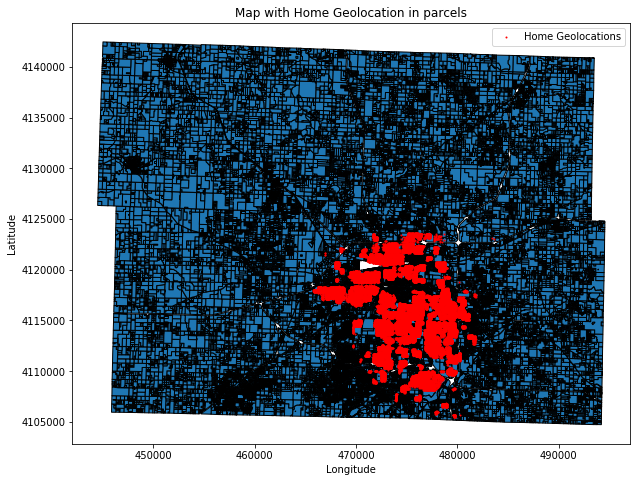

In [50]:
# Set the geometry of gdf to the home_geolocation column
df.set_geometry('home_geolocation', inplace=True)

# Plot the filtered gdf
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map 
gdf_parcel_boundary.plot(ax=ax, edgecolor='black')

# Overlay the home_geolocation points on the same map
df.plot(ax=ax, marker='o', color='red', markersize=1, label='Home Geolocations')

ax.legend()

# Title and labels
plt.title('Map with Home Geolocation in parcels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


In [52]:
# Filter rows where the city is 'SPRINGFIELD' in the gdf_parcel_boundary 
gdf_parcel_boundary = gdf_parcel_boundary[gdf_parcel_boundary['city'] == 'SPRINGFIELD']

# Print the filtered GeoDataFrame
print(gdf_parcel_boundary.shape)


(88739, 19)


In [53]:
#check all the full dataset structure
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43445 entries, 0 to 43444
Data columns (total 58 columns):
home_geolocation                              43445 non-null geometry
address                                       43445 non-null object
zip5                                          43445 non-null object
drive_time_fire                               43433 non-null float64
drive_distance_fire                           43433 non-null float64
feature_geolocation_fire                      43433 non-null object
feature_address_fire                          43433 non-null object
feature_category_fire                         43433 non-null object
drive_time_police                             43433 non-null float64
drive_distance_police                         43433 non-null float64
feature_geolocation_police                    43433 non-null object
feature_address_police                        43433 non-null object
feature_category_police                       43433 non-null 

In [54]:

# Create an empty list to store the extracted data
extracted_data2 = []

# Iterate over the geolocations (points in df) and extract OBJECTID values
for idx, row in df.iterrows():
    point = row['home_geolocation']  # The point geometry
    address = row['address']  # Extract the address from the df
    
    # check 'point' is a valid Point geometry
    if not point.is_empty:
        # Find the corresponding block group in gdf_parcel_boundary by checking if the point is inside any MultiPolygon
        matching_rows = gdf_parcel_boundary[gdf_parcel_boundary['geom'].contains(point)]

        if not matching_rows.empty:
            # If a match is found, get the OBJECTID value from gdf_parcel_boundary
            geo_id = matching_rows.iloc[0]['objectid']
            
            # Extract the additional columns from gdf_parcel_boundary
            zip5 = matching_rows.iloc[0]['zip5']
            nsa = matching_rows.iloc[0]['nsa']
            bds_zone = matching_rows.iloc[0]['bds_zone']
            zoning = matching_rows.iloc[0]['zoning']
            
            # Append the data (point, OBJECTID, geometry, address, and additional columns) to the list
            extracted_data2.append({
                'Point': point,
                'objectid': geo_id,
                'geometry': matching_rows.iloc[0]['geom'],  # Add the geometry from the matched parcel
                'address': address,  # Add the address from df
                'zip5': zip5,  # Add ZIP5 from gdf_parcel_boundary
                'nsa': nsa,  # Add NSA from gdf_parcel_boundary
                'bds_zone': bds_zone,  # Add BDS_ZONE from gdf_parcel_boundary
                'zoning': zoning  # Add ZONING from gdf_parcel_boundary
            })

# Convert the list of data to a DataFrame
extracted_df2 = pd.DataFrame(extracted_data2)



In [56]:
#check the shape
extracted_df2.shape

(43382, 8)

In [57]:
#check sample
extracted_df2.head()

,Point,objectid,geometry,address,zip5,nsa,bds_zone,zoning
0,POINT (478828.035603982 4106430.367284188),109976,(POLYGON ((478830.0455837253 4106448.353078863...,2840 E TARA CT,65804,ZONE4,C,R-SF
1,POINT (478863.0816719007 4106437.207127533),109977,(POLYGON ((478877.0910780851 4106417.316366467...,2846 E TARA CT,65804,ZONE4,C,R-SF
2,POINT (478890.4120425103 4106437.066773402),107290,(POLYGON ((478904.6889879957 4106417.474010851...,2852 E TARA CT,65804,ZONE4,C,R-SF
3,POINT (478920.5880107955 4106437.843421993),55192,(POLYGON ((478913.7599106763 4106460.939271136...,2856 E TARA CT,65804,ZONE4,C,R-SF
4,POINT (478953.7997819052 4106446.339458656),88558,(POLYGON ((478977.0374005281 4106456.618510301...,5920 S BELGRAVIA AVE,65804,ZONE4,C,R-SF


In [58]:
#check structure
extracted_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43382 entries, 0 to 43381
Data columns (total 8 columns):
Point       43382 non-null object
objectid    43382 non-null int64
geometry    43382 non-null object
address     43382 non-null object
zip5        43382 non-null object
nsa         43382 non-null object
bds_zone    43382 non-null object
zoning      43382 non-null object
dtypes: int64(1), object(7)
memory usage: 2.6+ MB


In [60]:
# Load dataset of blkgrp joined df
df1 = extracted_df
# Load dataset of parcels joined df
df2 = extracted_df2

In [63]:
#rename columns of blkgrp joined df
df1 = df1.rename(columns={
    "Point": "home_geolocation",
    "GEOIDFQ": "block_group_id",
    "ADDRESS": "address",
    "geometry": "block_group_geometry"
})

In [64]:
#check sample of blkgrp joined df
df1.head()

,home_geolocation,block_group_id,block_group_geometry,address
0,POINT (479731.1567271573 4105446.196936952),1500000US290770038011,"POLYGON ((479343.8751168707 4106052.08007338, ...",6525 S MEADOWVIEW AVE
1,POINT (479701.5227639587 4105456.646765461),1500000US290770038011,"POLYGON ((479343.8751168707 4106052.08007338, ...",6519 S MEADOWVIEW AVE
2,POINT (479759.3414113432 4105462.899646826),1500000US290770038011,"POLYGON ((479343.8751168707 4106052.08007338, ...",6520 S MEADOWVIEW AVE
3,POINT (479700.7700887901 4105489.945791545),1500000US290770038011,"POLYGON ((479343.8751168707 4106052.08007338, ...",6513 S MEADOWVIEW AVE
4,POINT (479765.5823243539 4105489.617898807),1500000US290770038011,"POLYGON ((479343.8751168707 4106052.08007338, ...",6512 S MEADOWVIEW AVE


In [65]:
#rename columns of parcels joined df
df2 = df2.rename(columns={
    "Point": "home_geolocation",
    "OBJECTID": "parcel_object_id",
    "ADDRESS": "address",
    "geometry": "parcel_geometry"
})


In [66]:
#check sample of parcels joined df
df2.head()

,home_geolocation,objectid,parcel_geometry,address,zip5,nsa,bds_zone,zoning
0,POINT (478828.035603982 4106430.367284188),109976,(POLYGON ((478830.0455837253 4106448.353078863...,2840 E TARA CT,65804,ZONE4,C,R-SF
1,POINT (478863.0816719007 4106437.207127533),109977,(POLYGON ((478877.0910780851 4106417.316366467...,2846 E TARA CT,65804,ZONE4,C,R-SF
2,POINT (478890.4120425103 4106437.066773402),107290,(POLYGON ((478904.6889879957 4106417.474010851...,2852 E TARA CT,65804,ZONE4,C,R-SF
3,POINT (478920.5880107955 4106437.843421993),55192,(POLYGON ((478913.7599106763 4106460.939271136...,2856 E TARA CT,65804,ZONE4,C,R-SF
4,POINT (478953.7997819052 4106446.339458656),88558,(POLYGON ((478977.0374005281 4106456.618510301...,5920 S BELGRAVIA AVE,65804,ZONE4,C,R-SF


In [67]:
#check shape of blkgrp joined df
df1.shape

(43445, 4)

In [68]:
#check structure of blkgrp joined df
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43445 entries, 0 to 43444
Data columns (total 4 columns):
home_geolocation        43445 non-null object
block_group_id          43445 non-null object
block_group_geometry    43445 non-null object
address                 43445 non-null object
dtypes: object(4)
memory usage: 1.3+ MB


In [69]:
#check shape of parcels joined df
df2.shape

(43382, 8)

In [70]:
#check structure of parcels joined df
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43382 entries, 0 to 43381
Data columns (total 8 columns):
home_geolocation    43382 non-null object
objectid            43382 non-null int64
parcel_geometry     43382 non-null object
address             43382 non-null object
zip5                43382 non-null object
nsa                 43382 non-null object
bds_zone            43382 non-null object
zoning              43382 non-null object
dtypes: int64(1), object(7)
memory usage: 2.6+ MB


In [71]:
# Extract unique addresses from both DataFrames
df1_unique_addresses = df1['address'].unique()
df2_unique_addresses = df2['address'].unique()

# Convert to sets for efficient set operations
df1_address_set = set(df1_unique_addresses)
df2_address_set = set(df2_unique_addresses)

# Perform a set difference operation to find addresses in df2 that are not in df1
addresses_in_df2_not_in_df1 = df2_address_set - df1_address_set

# Display the result
print("Addresses in df2 but not in df1:")
print(addresses_in_df2_not_in_df1)


Addresses in df2 but not in df1:
set()


In [75]:
#join the datasets
df_merged = df1.merge(df2, on=["address"], how="inner")

# If there are any duplicate columns (except the join keys), remove one set
df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]

In [76]:
# Rename 'home_geolocation_x' to 'home_geolocation'
df_merged.rename(columns={'home_geolocation_x': 'home_geolocation'}, inplace=True)

# Drop 'home_geolocation_y' column
df_merged.drop(columns=['home_geolocation_y'], inplace=True)

# Display the resulting DataFrame
df_merged.head()


,home_geolocation,block_group_id,block_group_geometry,address,objectid,parcel_geometry,zip5,nsa,bds_zone,zoning
0,POINT (478828.035603982 4106430.367284188),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2840 E TARA CT,109976,(POLYGON ((478830.0455837253 4106448.353078863...,65804,ZONE4,C,R-SF
1,POINT (478863.0816719007 4106437.207127533),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2846 E TARA CT,109977,(POLYGON ((478877.0910780851 4106417.316366467...,65804,ZONE4,C,R-SF
2,POINT (478890.4120425103 4106437.066773402),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2852 E TARA CT,107290,(POLYGON ((478904.6889879957 4106417.474010851...,65804,ZONE4,C,R-SF
3,POINT (478920.5880107955 4106437.843421993),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2856 E TARA CT,55192,(POLYGON ((478913.7599106763 4106460.939271136...,65804,ZONE4,C,R-SF
4,POINT (478953.7997819052 4106446.339458656),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",5920 S BELGRAVIA AVE,88558,(POLYGON ((478977.0374005281 4106456.618510301...,65804,ZONE4,C,R-SF


In [77]:
#check shape now
df_merged.shape

(43384, 10)

In [ ]:
#Create the connection and extract data from 'springfield_neighborhood_service_areas' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the springfield_neighborhood_service_areas table
query = "SELECT * FROM springfield_neighborhood_service_areas;"

try:
    nsa = gpd.read_postgis(query, conn, geom_col='geom')
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
print(nsa.shape)
#sample 
nsa.head()




I am able to connect to the database
Data extracted successfully!
(38, 7)


,objectid_1,name,shapestare,shapestlen,shape_length,shape_area,geom
0,1,Grant Beach,3.107893e+07,22403.823703,6826.057182,2.885105e+06,"MULTIPOLYGON (((474089.118 4120469.519, 474088..."
1,2,Oak Grove,5.694040e+07,32119.505522,9786.311928,5.285924e+06,"MULTIPOLYGON (((480052.310 4114905.475, 480052..."
2,3,Midtown,2.839690e+07,21373.071458,6512.016504,2.636137e+06,"MULTIPOLYGON (((475419.924 4118741.896, 475052..."
3,4,Weller,2.558836e+07,20759.618765,6325.117077,2.375422e+06,"MULTIPOLYGON (((476778.203 4118815.866, 476776..."
4,5,Woodland Heights,2.922756e+07,23012.009407,7011.363483,2.713241e+06,"MULTIPOLYGON (((472934.565 4120381.619, 472883..."


In [80]:
#Check sample of accessibility distance and times
df.head()

,home_geolocation,address,zip5,drive_time_fire,drive_distance_fire,feature_geolocation_fire,feature_address_fire,feature_category_fire,drive_time_police,drive_distance_police,...,drive_time_urgentcare,drive_distance_urgentcare,feature_geolocation_urgentcare,feature_address_urgentcare,feature_category_urgentcare,drive_time_trailheads,drive_distance_trailheads,feature_geolocation_trailheads,feature_address_trailheads,feature_category_trailheads
0,POINT (479731.157 4105446.197),6525 S MEADOWVIEW AVE,65721,4.19,1.6,POINT (477459.2576485137 4106497.905080578),2251 E FR188,BATTLEFIELD STA 2,14.4,8.33,...,12.06,6.82,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.93,2.09,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
1,POINT (479701.523 4105456.647),6519 S MEADOWVIEW AVE,65721,4.19,1.6,POINT (477459.2576485137 4106497.905080578),2251 E FR188,BATTLEFIELD STA 2,14.4,8.33,...,12.06,6.82,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.93,2.09,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
2,POINT (479759.341 4105462.900),6520 S MEADOWVIEW AVE,65721,4.19,1.6,POINT (477459.2576485137 4106497.905080578),2251 E FR188,BATTLEFIELD STA 2,14.4,8.33,...,12.06,6.82,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.93,2.09,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
3,POINT (479700.770 4105489.946),6513 S MEADOWVIEW AVE,65721,4.19,1.6,POINT (477459.2576485137 4106497.905080578),2251 E FR188,BATTLEFIELD STA 2,14.4,8.33,...,12.06,6.82,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.93,2.09,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
4,POINT (479765.582 4105489.618),6512 S MEADOWVIEW AVE,65721,4.19,1.6,POINT (477459.2576485137 4106497.905080578),2251 E FR188,BATTLEFIELD STA 2,14.4,8.33,...,12.06,6.82,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.93,2.09,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None


In [81]:
#Check shape of accessibility distance and times
df.shape

(43445, 58)

In [82]:
#Check structure of accessibility distance and times
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43445 entries, 0 to 43444
Data columns (total 58 columns):
home_geolocation                              43445 non-null geometry
address                                       43445 non-null object
zip5                                          43445 non-null object
drive_time_fire                               43433 non-null float64
drive_distance_fire                           43433 non-null float64
feature_geolocation_fire                      43433 non-null object
feature_address_fire                          43433 non-null object
feature_category_fire                         43433 non-null object
drive_time_police                             43433 non-null float64
drive_distance_police                         43433 non-null float64
feature_geolocation_police                    43433 non-null object
feature_address_police                        43433 non-null object
feature_category_police                       43433 non-null 

In [83]:
#check columns
df.columns

Index(['home_geolocation', 'address', 'zip5', 'drive_time_fire',
       'drive_distance_fire', 'feature_geolocation_fire',
       'feature_address_fire', 'feature_category_fire', 'drive_time_police',
       'drive_distance_police', 'feature_geolocation_police',
       'feature_address_police', 'feature_category_police',
       'drive_time_early_childhood_school',
       'drive_distance_early_childhood_school',
       'feature_geolocation_early_childhood_school',
       'feature_address_early_childhood_school',
       'feature_category_early_childhood_school',
       'drive_time_elementary_school', 'drive_distance_elementary_school',
       'feature_geolocation_elementary_school',
       'feature_address_elementary_school',
       'feature_category_elementary_school', 'drive_time_middle_school',
       'drive_distance_middle_school', 'feature_geolocation_middle_school',
       'feature_address_middle_school', 'feature_category_middle_school',
       'drive_time_high_school', 'drive_dist

In [84]:
#validate struture of merged data
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43384 entries, 0 to 43383
Data columns (total 10 columns):
home_geolocation        43384 non-null object
block_group_id          43384 non-null object
block_group_geometry    43384 non-null object
address                 43384 non-null object
objectid                43384 non-null int64
parcel_geometry         43384 non-null object
zip5                    43384 non-null object
nsa                     43384 non-null object
bds_zone                43384 non-null object
zoning                  43384 non-null object
dtypes: int64(1), object(9)
memory usage: 3.6+ MB


In [89]:
#convert the zip codes to integers
df['zip5'] = df['zip5'].astype(int)
df_merged['zip5'] = df_merged['zip5'].astype(int)

In [90]:
#join the two datasets 
df_full = df_merged.merge(df, on=["address","zip5"], how="inner")

# If there are any duplicate columns (except the join keys), remove one set
df_full = df_full.loc[:, ~df_full.columns.duplicated()]
#check shape
df_full.shape

(43388, 66)

In [91]:
# Rename 'home_geolocation_x' to 'home_geolocation'
df_full.rename(columns={'home_geolocation_x': 'home_geolocation'}, inplace=True)

# Drop 'home_geolocation_y' column
df_full.drop(columns=['home_geolocation_y'], inplace=True)



In [92]:
#check sample
df_full.head()

,home_geolocation,block_group_id,block_group_geometry,address,objectid,parcel_geometry,zip5,nsa,bds_zone,zoning,...,drive_time_urgentcare,drive_distance_urgentcare,feature_geolocation_urgentcare,feature_address_urgentcare,feature_category_urgentcare,drive_time_trailheads,drive_distance_trailheads,feature_geolocation_trailheads,feature_address_trailheads,feature_category_trailheads
0,POINT (478828.035603982 4106430.367284188),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2840 E TARA CT,109976,(POLYGON ((478830.0455837253 4106448.353078863...,65804,ZONE4,C,R-SF,...,12.77,7.13,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,4.64,2.40,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
1,POINT (478863.0816719007 4106437.207127533),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2846 E TARA CT,109977,(POLYGON ((478877.0910780851 4106417.316366467...,65804,ZONE4,C,R-SF,...,12.77,7.13,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,4.64,2.40,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
2,POINT (478890.4120425103 4106437.066773402),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2852 E TARA CT,107290,(POLYGON ((478904.6889879957 4106417.474010851...,65804,ZONE4,C,R-SF,...,12.77,7.13,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,4.64,2.40,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
3,POINT (478920.5880107955 4106437.843421993),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2856 E TARA CT,55192,(POLYGON ((478913.7599106763 4106460.939271136...,65804,ZONE4,C,R-SF,...,11.94,6.90,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.81,2.17,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None
4,POINT (478953.7997819052 4106446.339458656),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",5920 S BELGRAVIA AVE,88558,(POLYGON ((478977.0374005281 4106456.618510301...,65804,ZONE4,C,R-SF,...,11.94,6.90,POINT (473635.9039913416 4110497.096627527),4049 SOUTH CAMPBELL AVENUE,None,3.81,2.17,POINT (479103.716868555 4108184.36708939),5100 S Southwood Rd,None


In [93]:
#Check columns list
df_full.columns

Index(['home_geolocation', 'block_group_id', 'block_group_geometry', 'address',
       'objectid', 'parcel_geometry', 'zip5', 'nsa', 'bds_zone', 'zoning',
       'drive_time_fire', 'drive_distance_fire', 'feature_geolocation_fire',
       'feature_address_fire', 'feature_category_fire', 'drive_time_police',
       'drive_distance_police', 'feature_geolocation_police',
       'feature_address_police', 'feature_category_police',
       'drive_time_early_childhood_school',
       'drive_distance_early_childhood_school',
       'feature_geolocation_early_childhood_school',
       'feature_address_early_childhood_school',
       'feature_category_early_childhood_school',
       'drive_time_elementary_school', 'drive_distance_elementary_school',
       'feature_geolocation_elementary_school',
       'feature_address_elementary_school',
       'feature_category_elementary_school', 'drive_time_middle_school',
       'drive_distance_middle_school', 'feature_geolocation_middle_school',
       'f

# Merging casestudy data

In [ ]:
#Create the connection and extract data from 'demographics_master' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select 2022 data from the demographics_master table
query = "SELECT * FROM demographics_master where year = 2022;"

try:
    df1 = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
df1.shape

I am able to connect to the database
Data extracted successfully!


(5031, 52)

In [ ]:
#Create the connection and extract data from 'housing_pct_change_stats_data' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the housing_pct_change_stats_data table
query = "SELECT * FROM housing_pct_change_stats_data;"

try:
    df2 = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
df2.shape



I am able to connect to the database
Data extracted successfully!


(5031, 24)

In [ ]:
#Create the connection and extract data from 'housing_stats_data' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select 2022 data from the housing_stats_data table
query = "SELECT * FROM housing_stats_data where year = 2022;"

try:
    df3 = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
df3.shape





I am able to connect to the database
Data extracted successfully!


(5031, 45)

In [97]:
#Check the columns in demographics_master
df1.columns

Index(['geo_id', 'year', 'total_population', 'shannon_index', 'simpsons_index',
       'richness', 'simpson_dominance', 'berger_parker_dominance',
       'simpson_evenness', 'block_group', 'census_tract', 'county', 'state',
       'group_classification', 'hispanic_or_latino', 'asian', 'black',
       'native', 'other', 'pac_isl', 'two_or_more_races', 'white',
       'gini_education', 'weighted_education_score',
       'higher_education_proportion', 'education_score_category',
       'no_schooling', 'prek_8th', 'some_high_school_no_diploma',
       'high_school_graduate', 'some_college_no_degree', 'associates_degree',
       'bachelors_degree', 'advanced_degree', 'median_income',
       'gini_coefficient', 'est_less_than_10k', 'est_10to15k', 'est_15to20k',
       'est_20to25k', 'est_25to30k', 'est_30to35k', 'est_35to40k',
       'est_40to45k', 'est_45to50k', 'est_50to60k', 'est_60to75k',
       'est_75to100k', 'est_100to125k', 'est_125to150k', 'est_150to200k',
       'est_more_than_200k

In [98]:
#Check the columns in housing_pct_change_stats_data
df2.columns

Index(['geo_id', 'pct_occupied_chg_20_21', 'pct_occupied_chg_21_22',
       'pct_occupied_chg_20_22', 'pct_vacant_chg_20_21',
       'pct_vacant_chg_21_22', 'pct_vacant_chg_20_22',
       'pct_owner_occupied_chg_20_21', 'pct_owner_occupied_chg_21_22',
       'pct_owner_occupied_chg_20_22', 'pct_rental_chg_20_21',
       'pct_rental_chg_21_22', 'pct_rental_chg_20_22', 'block_group',
       'census_tract', 'county', 'state', 'housing_consistency',
       'occupancy_consistency', 'housing_chg_20_22', 'occupancy_chg_20_22',
       'pct_value_chg_20_21', 'pct_value_chg_21_22', 'pct_value_chg_20_22'],
      dtype='object')

In [99]:
#Check the columns in housing_stats_data
df3.columns

Index(['geo_id', 'median_value', 'total_estimate', 'est_total_occupied',
       'est_total_vacant', 'est_total_owner_occupied', 'est_total_rental',
       'estimate_total_less_than_10000', 'estimate_total_10000_to_14999',
       'estimate_total_15000_to_19999', 'estimate_total_20000_to_24999',
       'estimate_total_25000_to_29999', 'estimate_total_30000_to_34999',
       'estimate_total_35000_to_39999', 'estimate_total_40000_to_49999',
       'estimate_total_50000_to_59999', 'estimate_total_60000_to_69999',
       'estimate_total_70000_to_79999', 'estimate_total_80000_to_89999',
       'estimate_total_90000_to_99999', 'estimate_total_100000_to_124999',
       'estimate_total_125000_to_149999', 'estimate_total_150000_to_174999',
       'estimate_total_175000_to_199999', 'estimate_total_200000_to_249999',
       'estimate_total_250000_to_299999', 'estimate_total_300000_to_399999',
       'estimate_total_400000_to_499999', 'estimate_total_500000_to_749999',
       'estimate_total_750000_

In [100]:
#subset the columns that are needed for User interface - Set 1
list_columns = ['geo_id', 'total_population', 'block_group', 'census_tract', 'county', 'state', 'median_income', 'education_score_category','group_classification']
df1_subset = df1[list_columns]
df1_subset.columns

Index(['geo_id', 'total_population', 'block_group', 'census_tract', 'county',
       'state', 'median_income', 'education_score_category',
       'group_classification'],
      dtype='object')

In [101]:
#subset the columns that are needed for User interface - set 2
df2_subset_columns = ['geo_id', 'housing_consistency', 'occupancy_consistency', 'housing_chg_20_22', 'occupancy_chg_20_22', 'pct_value_chg_20_22']
df2_subset = df2[df2_subset_columns]
df2_subset.columns

Index(['geo_id', 'housing_consistency', 'occupancy_consistency',
       'housing_chg_20_22', 'occupancy_chg_20_22', 'pct_value_chg_20_22'],
      dtype='object')

In [102]:
# do inner join on the 'geo_id' column
merged_df = pd.merge(df1_subset, df2_subset, on='geo_id', how='inner')
merged_df.columns

Index(['geo_id', 'total_population', 'block_group', 'census_tract', 'county',
       'state', 'median_income', 'education_score_category',
       'group_classification', 'housing_consistency', 'occupancy_consistency',
       'housing_chg_20_22', 'occupancy_chg_20_22', 'pct_value_chg_20_22'],
      dtype='object')

In [103]:
#check shape
merged_df.shape

(5031, 14)

In [104]:
#subset the columns that are needed for User interface - set 3
df3_subset_columns = ['geo_id', 'median_value', 'est_total_vacant',
                      'est_total_owner_occupied', 'pct_vacant', 'pct_owner_occupied', 'housing_category']
df3_subset = df3[df3_subset_columns]
df3_subset.columns

Index(['geo_id', 'median_value', 'est_total_vacant',
       'est_total_owner_occupied', 'pct_vacant', 'pct_owner_occupied',
       'housing_category'],
      dtype='object')

In [105]:
# Perform an inner join on the 'geo_id' column
merged_df_final = pd.merge(merged_df, df3_subset, on='geo_id', how='inner')
#check final columns list
merged_df_final.columns

Index(['geo_id', 'total_population', 'block_group', 'census_tract', 'county',
       'state', 'median_income', 'education_score_category',
       'group_classification', 'housing_consistency', 'occupancy_consistency',
       'housing_chg_20_22', 'occupancy_chg_20_22', 'pct_value_chg_20_22',
       'median_value', 'est_total_vacant', 'est_total_owner_occupied',
       'pct_vacant', 'pct_owner_occupied', 'housing_category'],
      dtype='object')

In [106]:
#check shape
merged_df_final.shape

(5031, 20)

In [107]:
#Check sample
merged_df_final.head()

,geo_id,total_population,block_group,census_tract,county,state,median_income,education_score_category,group_classification,housing_consistency,occupancy_consistency,housing_chg_20_22,occupancy_chg_20_22,pct_value_chg_20_22,median_value,est_total_vacant,est_total_owner_occupied,pct_vacant,pct_owner_occupied,housing_category
0,1500000US290370613001,644,Block Group 1,Census Tract 613,Cass County,Missouri,54318.0,Low,Mixed Race Dominant,zero_change,ren_pos,No Change or No Units,Rental Increase,3.79,142500,0,106,0.000000,46.491228,Occupied-Rental
1,1500000US290019501001,1121,Block Group 1,Census Tract 9501,Adair County,Missouri,80208.0,Medium,white Dominant with low diversity,Inconsistent,ren_pos,Vacancy Increase,Rental Increase,25.72,178900,150,405,25.996534,94.847775,Occupied-Owner
2,1500000US290019501002,1589,Block Group 2,Census Tract 9501,Adair County,Missouri,64196.0,Medium,white Dominant with low diversity,Inconsistent,Inconsistent,Occupancy Increase,Rental Increase,12.68,167100,80,523,11.560694,85.457516,Occupied-Owner
3,1500000US290019501003,961,Block Group 3,Census Tract 9501,Adair County,Missouri,52438.0,Medium,white Dominant with high diversity,occ_pos,ren_pos,Occupancy Increase,Rental Increase,9.99,94700,132,275,29.398664,86.750789,Occupied-Owner
4,1500000US290019502001,1031,Block Group 1,Census Tract 9502,Adair County,Missouri,46000.0,Low,white Dominant with high diversity,vac_pos,Inconsistent,Vacancy Increase,Ownership Increase,18.59,89300,159,273,33.056133,84.782609,Occupied-Owner


In [108]:
# Split the 'group_classification' column into 'race' and 'diversity' columns
merged_df_final[['race', 'diversity']] = merged_df_final['group_classification'].str.split(' ', 1, expand=True)

# Remove the unwanted 'Dominant with ' part from the 'diversity' column
merged_df_final['diversity'] = merged_df_final['diversity'].str.replace('Dominant with ', '', regex=False)

# Replace 'Race Dominant' values in the 'diversity' column with blank
merged_df_final['diversity'] = merged_df_final['diversity'].replace('Race Dominant', '')

#  extra spaces, strip them
merged_df_final['race'] = merged_df_final['race'].str.strip()
merged_df_final['diversity'] = merged_df_final['diversity'].str.strip()
#check data
merged_df_final.head()

,geo_id,total_population,block_group,census_tract,county,state,median_income,education_score_category,group_classification,housing_consistency,...,occupancy_chg_20_22,pct_value_chg_20_22,median_value,est_total_vacant,est_total_owner_occupied,pct_vacant,pct_owner_occupied,housing_category,race,diversity
0,1500000US290370613001,644,Block Group 1,Census Tract 613,Cass County,Missouri,54318.0,Low,Mixed Race Dominant,zero_change,...,Rental Increase,3.79,142500,0,106,0.000000,46.491228,Occupied-Rental,Mixed,
1,1500000US290019501001,1121,Block Group 1,Census Tract 9501,Adair County,Missouri,80208.0,Medium,white Dominant with low diversity,Inconsistent,...,Rental Increase,25.72,178900,150,405,25.996534,94.847775,Occupied-Owner,white,low diversity
2,1500000US290019501002,1589,Block Group 2,Census Tract 9501,Adair County,Missouri,64196.0,Medium,white Dominant with low diversity,Inconsistent,...,Rental Increase,12.68,167100,80,523,11.560694,85.457516,Occupied-Owner,white,low diversity
3,1500000US290019501003,961,Block Group 3,Census Tract 9501,Adair County,Missouri,52438.0,Medium,white Dominant with high diversity,occ_pos,...,Rental Increase,9.99,94700,132,275,29.398664,86.750789,Occupied-Owner,white,high diversity
4,1500000US290019502001,1031,Block Group 1,Census Tract 9502,Adair County,Missouri,46000.0,Low,white Dominant with high diversity,vac_pos,...,Ownership Increase,18.59,89300,159,273,33.056133,84.782609,Occupied-Owner,white,high diversity


In [109]:
# Drop the 'group_classification' column from merged_df_final
merged_df_final = merged_df_final.drop(columns=['group_classification'])


In [110]:
#Filter Greene county
df_greene = merged_df_final[merged_df_final["county"] == "Greene County"]
#check shape
df_greene.shape

(242, 21)

In [111]:
#check data
df_greene.head()

,geo_id,total_population,block_group,census_tract,county,state,median_income,education_score_category,housing_consistency,occupancy_consistency,...,occupancy_chg_20_22,pct_value_chg_20_22,median_value,est_total_vacant,est_total_owner_occupied,pct_vacant,pct_owner_occupied,housing_category,race,diversity
1210,1500000US290770001011,1095,Block Group 1,Census Tract 1.01,Greene County,Missouri,29073.0,Medium,occ_pos,own_occ_pos,...,Ownership Increase,2.82,163384,6,23,0.855920,3.309353,Occupied-Rental,white,high diversity
1211,1500000US290770001021,415,Block Group 1,Census Tract 1.02,Greene County,Missouri,14242.0,High,occ_pos,zero_change,...,No Change or No Units,0.00,0,0,0,0.000000,0.000000,Occupied-Rental,white,high diversity
1212,1500000US290770001022,1258,Block Group 2,Census Tract 1.02,Greene County,Missouri,22939.0,Medium,occ_pos,Inconsistent,...,Rental Increase,-100.00,0,0,0,0.000000,0.000000,Occupied-Rental,white,high diversity
1213,1500000US290770002001,3705,Block Group 1,Census Tract 2,Greene County,Missouri,23042.0,Medium,occ_pos,Inconsistent,...,Rental Increase,-11.44,6116,91,45,9.599156,5.250875,Occupied-Rental,white,high diversity
1214,1500000US290770002002,2118,Block Group 2,Census Tract 2,Greene County,Missouri,16332.0,Very Low,occ_pos,zero_change,...,No Change or No Units,0.00,0,67,0,10.737179,0.000000,Occupied-Rental,white,high diversity


In [112]:
#rename column
df_greene = df_greene.rename(columns={
    "geo_id": "block_group_id"
})

In [113]:
#check columns
df_greene.columns

Index(['block_group_id', 'total_population', 'block_group', 'census_tract',
       'county', 'state', 'median_income', 'education_score_category',
       'housing_consistency', 'occupancy_consistency', 'housing_chg_20_22',
       'occupancy_chg_20_22', 'pct_value_chg_20_22', 'median_value',
       'est_total_vacant', 'est_total_owner_occupied', 'pct_vacant',
       'pct_owner_occupied', 'housing_category', 'race', 'diversity'],
      dtype='object')

In [115]:
#merge with full dataset
df_full = df_full.merge(df_greene, on="block_group_id", how="left")
#check sample
df_full.head()

,home_geolocation,block_group_id,block_group_geometry,address,objectid,parcel_geometry,zip5,nsa,bds_zone,zoning,...,occupancy_chg_20_22,pct_value_chg_20_22,median_value,est_total_vacant,est_total_owner_occupied,pct_vacant,pct_owner_occupied,housing_category,race,diversity
0,POINT (478828.035603982 4106430.367284188),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2840 E TARA CT,109976,(POLYGON ((478830.0455837253 4106448.353078863...,65804,ZONE4,C,R-SF,...,Ownership Increase,14.52,348700,0,509,0.0,83.034258,Occupied-Owner,white,low diversity
1,POINT (478863.0816719007 4106437.207127533),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2846 E TARA CT,109977,(POLYGON ((478877.0910780851 4106417.316366467...,65804,ZONE4,C,R-SF,...,Ownership Increase,14.52,348700,0,509,0.0,83.034258,Occupied-Owner,white,low diversity
2,POINT (478890.4120425103 4106437.066773402),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2852 E TARA CT,107290,(POLYGON ((478904.6889879957 4106417.474010851...,65804,ZONE4,C,R-SF,...,Ownership Increase,14.52,348700,0,509,0.0,83.034258,Occupied-Owner,white,low diversity
3,POINT (478920.5880107955 4106437.843421993),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2856 E TARA CT,55192,(POLYGON ((478913.7599106763 4106460.939271136...,65804,ZONE4,C,R-SF,...,Ownership Increase,14.52,348700,0,509,0.0,83.034258,Occupied-Owner,white,low diversity
4,POINT (478953.7997819052 4106446.339458656),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",5920 S BELGRAVIA AVE,88558,(POLYGON ((478977.0374005281 4106456.618510301...,65804,ZONE4,C,R-SF,...,Ownership Increase,14.52,348700,0,509,0.0,83.034258,Occupied-Owner,white,low diversity


In [116]:
#check shape
df_full.shape

(43388, 85)

In [117]:
#check columns
df_full.columns

Index(['home_geolocation', 'block_group_id', 'block_group_geometry', 'address',
       'objectid', 'parcel_geometry', 'zip5', 'nsa', 'bds_zone', 'zoning',
       'drive_time_fire', 'drive_distance_fire', 'feature_geolocation_fire',
       'feature_address_fire', 'feature_category_fire', 'drive_time_police',
       'drive_distance_police', 'feature_geolocation_police',
       'feature_address_police', 'feature_category_police',
       'drive_time_early_childhood_school',
       'drive_distance_early_childhood_school',
       'feature_geolocation_early_childhood_school',
       'feature_address_early_childhood_school',
       'feature_category_early_childhood_school',
       'drive_time_elementary_school', 'drive_distance_elementary_school',
       'feature_geolocation_elementary_school',
       'feature_address_elementary_school',
       'feature_category_elementary_school', 'drive_time_middle_school',
       'drive_distance_middle_school', 'feature_geolocation_middle_school',
       'f

In [118]:
# Display all columns with their null counts
pd.set_option('display.max_rows', None)  
null_counts = df_full.isnull().sum()
print(null_counts)


home_geolocation                                  0
block_group_id                                    0
block_group_geometry                              0
address                                           0
objectid                                          0
parcel_geometry                                   0
zip5                                              0
nsa                                               0
bds_zone                                          0
zoning                                            0
drive_time_fire                                  12
drive_distance_fire                              12
feature_geolocation_fire                         12
feature_address_fire                             12
feature_category_fire                            12
drive_time_police                                12
drive_distance_police                            12
feature_geolocation_police                       12
feature_address_police                           12
feature_cate

# Creating Synthetic Housing Data

In [119]:
# For each unique block_group_id, generate synthetic house prices
def generate_synthetic_house_price(group_df):
    # Get the median_value for the block group
    median_value = group_df["median_value"].iloc[0]  # Making the value is the same for all rows in this block group

    # Generate synthetic values by adding noise
    noise = np.random.uniform(-0.1 * median_value, 0.1 * median_value, size=len(group_df))

    # Create the synthetic house price by adding the noise to the median_value
    group_df["house_price"] = median_value + noise
    return group_df

# Apply the function to each block group
df_full_with_house_price = df_full.groupby("block_group_id").apply(generate_synthetic_house_price)



In [120]:
# duplicate the  dataset 
df_full = df_full_with_house_price

In [121]:
# Function to generate synthetic property features based on house price
def generate_synthetic_property_features(group_df):
    # Create synthetic features based on house price
    house_prices = group_df["house_price"]

    # Bedrooms: Higher house price typically means more bedrooms (from 1 to 6)
    group_df["bedrooms"] = np.random.randint(1, 7, size=len(group_df)) + np.where(house_prices > house_prices.median(), 0, 0)

    # Bathrooms: Higher house price typically means more bathrooms (1 to 5, with 0.5 increments)
    group_df["bathrooms"] = np.random.choice([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], size=len(group_df))

    # Square Footage: Larger houses for higher prices (1000 to 3500, with some extreme outliers)
    group_df["square_footage"] = np.random.randint(1000, 3501, size=len(group_df)) + np.where(house_prices > house_prices.median(), np.random.randint(0, 1000), 0)

    # Lot Size: Larger lot size for higher prices (10000 to 20000 sq ft, with some outliers for high house prices)
    group_df["lot_size"] = np.random.randint(10000, 20001, size=len(group_df)) + np.where(house_prices > house_prices.median(), np.random.randint(1000, 5000), 0)

    # Year Built: Newer homes for higher prices (1960 to 2021, with fewer older homes for higher house prices)
    # make year_built  between 1960 and 2021
    group_df["year_built"] = np.random.randint(1960, 2022, size=len(group_df)) + np.where(house_prices > house_prices.median(), 0, 0)
    group_df["year_built"] = np.clip(group_df["year_built"], 1960, 2021)  

    return group_df

# Apply the function to each block group
df_full_with_features = df_full.groupby("block_group_id").apply(generate_synthetic_property_features)



In [123]:
# duplicate dataset
df_full_non_nsa = df_full_with_features

# Additional Data carpentry for adding neighborhood service area

In [124]:
#check sample
df_full_non_nsa.head()

,home_geolocation,block_group_id,block_group_geometry,address,objectid,parcel_geometry,zip5,nsa,bds_zone,zoning,...,pct_owner_occupied,housing_category,race,diversity,house_price,bedrooms,bathrooms,square_footage,lot_size,year_built
0,POINT (478828.035603982 4106430.367284188),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2840 E TARA CT,109976,(POLYGON ((478830.0455837253 4106448.353078863...,65804,ZONE4,C,R-SF,...,83.034258,Occupied-Owner,white,low diversity,368495.199053,5,3.5,1706,17855,1983
1,POINT (478863.0816719007 4106437.207127533),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2846 E TARA CT,109977,(POLYGON ((478877.0910780851 4106417.316366467...,65804,ZONE4,C,R-SF,...,83.034258,Occupied-Owner,white,low diversity,333961.627714,5,2.5,1173,18280,2009
2,POINT (478890.4120425103 4106437.066773402),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2852 E TARA CT,107290,(POLYGON ((478904.6889879957 4106417.474010851...,65804,ZONE4,C,R-SF,...,83.034258,Occupied-Owner,white,low diversity,358686.215774,5,5.0,3367,15016,1991
3,POINT (478920.5880107955 4106437.843421993),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2856 E TARA CT,55192,(POLYGON ((478913.7599106763 4106460.939271136...,65804,ZONE4,C,R-SF,...,83.034258,Occupied-Owner,white,low diversity,346362.075920,3,2.0,2481,15586,2000
4,POINT (478953.7997819052 4106446.339458656),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",5920 S BELGRAVIA AVE,88558,(POLYGON ((478977.0374005281 4106456.618510301...,65804,ZONE4,C,R-SF,...,83.034258,Occupied-Owner,white,low diversity,359821.771482,2,5.0,1627,21441,1974


In [125]:
#check unique neighborhood service areas in dataset merged using homes
df_full_non_nsa['nsa'].unique()

array(['ZONE4', 'ZONE3', 'MARK TWAIN', 'LAKE SGF', 'SOUTHSIDE',
       'GLWYVILL', 'PARKCREST', 'KICKAPOO', 'BRADFRD PK', 'BRENTWOOD',
       'SRN HILLS', 'MEADOR PK', 'SEMINOLE', 'SHERWOOD', 'FASSNIGHT',
       'PHELPS', 'DELAWARE', 'OAK GROVE', 'ZONE2', 'EWING', 'BINGHAM',
       'ROUNTREE', 'W CENTRAL', 'YNG LILLY', 'WESTSIDE', 'GRANT BCH',
       'COOPER PK', 'BISSETT', 'HRT WSIDE', 'WELLER', 'ZONE1', 'MIDTOWN',
       'WOODLAND', 'TOM WATKIN', 'PARKWOOD', 'DOLING PK'], dtype=object)

In [126]:
#check shape
df_full_non_nsa.shape

(43388, 91)

In [127]:
#check unique neighborhood service areas in dataset extracted from the geospatial layer
nsa['name'].unique()

array(['Grant Beach', 'Oak Grove', 'Midtown', 'Weller',
       'Woodland Heights', 'Delaware', 'Tom Watkins', 'Cooper Park',
       'Robberson', 'Phelps/University Heights', 'Bingham', 'Doling Park',
       'Parkwood', 'Southern Hills', 'Downtown', 'Rountree/Walnut',
       'Seminole/Holland', 'Parkcrest', 'Heart of the Westside',
       'Bissett', 'Young Lilly', 'Fassnight', 'Westside', 'Ewing',
       'West Central', 'Sherwood', 'Mark Twain', 'Kickapoo', 'Brentwood',
       'Southside', 'Galloway Village', 'Lake Springfield', 'Meador Park',
       'Bradford Park', 'Zone 1', 'Zone 2', 'Zone 3', 'Zone 4'],
      dtype=object)

In [128]:
# Remove spaces, convert to uppercase, and remove words after '/'
nsa['name'] = nsa['name'].str.replace(r'\s+', '', regex=True).str.upper().str.split('/').str[0]

# Get unique values
unique_names = nsa['name'].unique()
print(unique_names)

['GRANTBEACH' 'OAKGROVE' 'MIDTOWN' 'WELLER' 'WOODLANDHEIGHTS' 'DELAWARE'
 'TOMWATKINS' 'COOPERPARK' 'ROBBERSON' 'PHELPS' 'BINGHAM' 'DOLINGPARK'
 'PARKWOOD' 'SOUTHERNHILLS' 'DOWNTOWN' 'ROUNTREE' 'SEMINOLE' 'PARKCREST'
 'HEARTOFTHEWESTSIDE' 'BISSETT' 'YOUNGLILLY' 'FASSNIGHT' 'WESTSIDE'
 'EWING' 'WESTCENTRAL' 'SHERWOOD' 'MARKTWAIN' 'KICKAPOO' 'BRENTWOOD'
 'SOUTHSIDE' 'GALLOWAYVILLAGE' 'LAKESPRINGFIELD' 'MEADORPARK'
 'BRADFORDPARK' 'ZONE1' 'ZONE2' 'ZONE3' 'ZONE4']


In [129]:
# Define mapping dictionary as the names are not matching
name_mapping = {
    'GRANTBEACH': 'GRANT BCH', 
    'OAKGROVE': 'OAK GROVE', 
    'SOUTHERNHILLS': 'SRN HILLS',
    'WOODLANDHEIGHTS': 'WOODLAND', 
    'COOPERPARK': 'COOPER PK', 
    'MEADORPARK': 'MEADOR PK',
    'MARKTWAIN': 'MARK TWAIN', 
    'BRADFORDPARK': 'BRADFRD PK', 
    'TOMWATKINS': 'TOM WATKIN',
    'HEARTOFTHEWESTSIDE': 'HRT WSIDE', 
    'YOUNGLILLY': 'YNG LILLY', 
    'LAKESPRINGFIELD': 'LAKE SGF',
    'WESTCENTRAL': 'W CENTRAL', 
    'GALLOWAYVILLAGE': 'GLWYVILL'
}

# Apply the mapping to the 'NAME' column
nsa['name'] = nsa['name'].replace(name_mapping)
nsa['name'] = nsa['name'].replace({'DOLINGPARK': 'DOLING PK'})
# Display the updated column
print(nsa['name'].unique())


['GRANT BCH' 'OAK GROVE' 'MIDTOWN' 'WELLER' 'WOODLAND' 'DELAWARE'
 'TOM WATKIN' 'COOPER PK' 'ROBBERSON' 'PHELPS' 'BINGHAM' 'DOLING PK'
 'PARKWOOD' 'SRN HILLS' 'DOWNTOWN' 'ROUNTREE' 'SEMINOLE' 'PARKCREST'
 'HRT WSIDE' 'BISSETT' 'YNG LILLY' 'FASSNIGHT' 'WESTSIDE' 'EWING'
 'W CENTRAL' 'SHERWOOD' 'MARK TWAIN' 'KICKAPOO' 'BRENTWOOD' 'SOUTHSIDE'
 'GLWYVILL' 'LAKE SGF' 'MEADOR PK' 'BRADFRD PK' 'ZONE1' 'ZONE2' 'ZONE3'
 'ZONE4']


In [130]:
#check the columns list
nsa.columns

Index(['objectid_1', 'name', 'shapestare', 'shapestlen', 'shape_length',
       'shape_area', 'geom'],
      dtype='object')

In [131]:
#rename the columns for join

nsa = nsa.rename(columns={'name': 'nsa', 'geom': 'nsa_polygon'})



In [132]:
#validate the column names again
nsa.head()

,objectid_1,nsa,shapestare,shapestlen,shape_length,shape_area,nsa_polygon
0,1,GRANT BCH,3.107893e+07,22403.823703,6826.057182,2.885105e+06,"MULTIPOLYGON (((474089.118 4120469.519, 474088..."
1,2,OAK GROVE,5.694040e+07,32119.505522,9786.311928,5.285924e+06,"MULTIPOLYGON (((480052.310 4114905.475, 480052..."
2,3,MIDTOWN,2.839690e+07,21373.071458,6512.016504,2.636137e+06,"MULTIPOLYGON (((475419.924 4118741.896, 475052..."
3,4,WELLER,2.558836e+07,20759.618765,6325.117077,2.375422e+06,"MULTIPOLYGON (((476778.203 4118815.866, 476776..."
4,5,WOODLAND,2.922756e+07,23012.009407,7011.363483,2.713241e+06,"MULTIPOLYGON (((472934.565 4120381.619, 472883..."


In [133]:
#compare the column names in full dataset
df_full_non_nsa.columns

Index(['home_geolocation', 'block_group_id', 'block_group_geometry', 'address',
       'objectid', 'parcel_geometry', 'zip5', 'nsa', 'bds_zone', 'zoning',
       'drive_time_fire', 'drive_distance_fire', 'feature_geolocation_fire',
       'feature_address_fire', 'feature_category_fire', 'drive_time_police',
       'drive_distance_police', 'feature_geolocation_police',
       'feature_address_police', 'feature_category_police',
       'drive_time_early_childhood_school',
       'drive_distance_early_childhood_school',
       'feature_geolocation_early_childhood_school',
       'feature_address_early_childhood_school',
       'feature_category_early_childhood_school',
       'drive_time_elementary_school', 'drive_distance_elementary_school',
       'feature_geolocation_elementary_school',
       'feature_address_elementary_school',
       'feature_category_elementary_school', 'drive_time_middle_school',
       'drive_distance_middle_school', 'feature_geolocation_middle_school',
       'f

In [134]:
# Perform a left join to add the 'nsa_polygon' column from 'nsa' dataset
df_full_with_nsa = df_full_non_nsa.merge(nsa[['nsa', 'nsa_polygon']], on='nsa', how='left')


# Check the shape to ensure records remain 43,388
print(df_full_with_nsa.shape)


(43388, 92)


In [135]:
# Display the first few rows to verify
df_full_with_nsa.head()


,home_geolocation,block_group_id,block_group_geometry,address,objectid,parcel_geometry,zip5,nsa,bds_zone,zoning,...,housing_category,race,diversity,house_price,bedrooms,bathrooms,square_footage,lot_size,year_built,nsa_polygon
0,POINT (478828.035603982 4106430.367284188),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2840 E TARA CT,109976,(POLYGON ((478830.0455837253 4106448.353078863...,65804,ZONE4,C,R-SF,...,Occupied-Owner,white,low diversity,368495.199053,5,3.5,1706,17855,1983,"MULTIPOLYGON (((480835.736 4114864.378, 480835..."
1,POINT (478863.0816719007 4106437.207127533),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2846 E TARA CT,109977,(POLYGON ((478877.0910780851 4106417.316366467...,65804,ZONE4,C,R-SF,...,Occupied-Owner,white,low diversity,333961.627714,5,2.5,1173,18280,2009,"MULTIPOLYGON (((480835.736 4114864.378, 480835..."
2,POINT (478890.4120425103 4106437.066773402),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2852 E TARA CT,107290,(POLYGON ((478904.6889879957 4106417.474010851...,65804,ZONE4,C,R-SF,...,Occupied-Owner,white,low diversity,358686.215774,5,5.0,3367,15016,1991,"MULTIPOLYGON (((480835.736 4114864.378, 480835..."
3,POINT (478920.5880107955 4106437.843421993),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",2856 E TARA CT,55192,(POLYGON ((478913.7599106763 4106460.939271136...,65804,ZONE4,C,R-SF,...,Occupied-Owner,white,low diversity,346362.075920,3,2.0,2481,15586,2000,"MULTIPOLYGON (((480835.736 4114864.378, 480835..."
4,POINT (478953.7997819052 4106446.339458656),1500000US290770040021,"POLYGON ((476590.2363704411 4107312.960920942,...",5920 S BELGRAVIA AVE,88558,(POLYGON ((478977.0374005281 4106456.618510301...,65804,ZONE4,C,R-SF,...,Occupied-Owner,white,low diversity,359821.771482,2,5.0,1627,21441,1974,"MULTIPOLYGON (((480835.736 4114864.378, 480835..."


In [137]:
#duplicate the dataset for reruns
final_data = df_full_with_nsa

In [138]:
#validate the columns
final_data.columns

Index(['home_geolocation', 'block_group_id', 'block_group_geometry', 'address',
       'objectid', 'parcel_geometry', 'zip5', 'nsa', 'bds_zone', 'zoning',
       'drive_time_fire', 'drive_distance_fire', 'feature_geolocation_fire',
       'feature_address_fire', 'feature_category_fire', 'drive_time_police',
       'drive_distance_police', 'feature_geolocation_police',
       'feature_address_police', 'feature_category_police',
       'drive_time_early_childhood_school',
       'drive_distance_early_childhood_school',
       'feature_geolocation_early_childhood_school',
       'feature_address_early_childhood_school',
       'feature_category_early_childhood_school',
       'drive_time_elementary_school', 'drive_distance_elementary_school',
       'feature_geolocation_elementary_school',
       'feature_address_elementary_school',
       'feature_category_elementary_school', 'drive_time_middle_school',
       'drive_distance_middle_school', 'feature_geolocation_middle_school',
       'f

In [139]:
# List of geometry columns to remove
columns_to_remove = ['block_group_geometry', 'parcel_geometry', 'nsa_polygon']

# Drop those columns from the final_data DataFrame
final_data = final_data.drop(columns=[col for col in columns_to_remove if col in final_data.columns])


In [140]:
#check the structure again
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43388 entries, 0 to 43387
Data columns (total 89 columns):
home_geolocation                              43388 non-null object
block_group_id                                43388 non-null object
address                                       43388 non-null object
objectid                                      43388 non-null int64
zip5                                          43388 non-null int64
nsa                                           43388 non-null object
bds_zone                                      43388 non-null object
zoning                                        43388 non-null object
drive_time_fire                               43376 non-null float64
drive_distance_fire                           43376 non-null float64
feature_geolocation_fire                      43376 non-null object
feature_address_fire                          43376 non-null object
feature_category_fire                         43376 non-null object
drive_t

In [141]:
#verify sample data
final_data.head()

,home_geolocation,block_group_id,address,objectid,zip5,nsa,bds_zone,zoning,drive_time_fire,drive_distance_fire,...,pct_owner_occupied,housing_category,race,diversity,house_price,bedrooms,bathrooms,square_footage,lot_size,year_built
0,POINT (478828.035603982 4106430.367284188),1500000US290770040021,2840 E TARA CT,109976,65804,ZONE4,C,R-SF,1.53,0.43,...,83.034258,Occupied-Owner,white,low diversity,368495.199053,5,3.5,1706,17855,1983
1,POINT (478863.0816719007 4106437.207127533),1500000US290770040021,2846 E TARA CT,109977,65804,ZONE4,C,R-SF,1.53,0.43,...,83.034258,Occupied-Owner,white,low diversity,333961.627714,5,2.5,1173,18280,2009
2,POINT (478890.4120425103 4106437.066773402),1500000US290770040021,2852 E TARA CT,107290,65804,ZONE4,C,R-SF,1.53,0.43,...,83.034258,Occupied-Owner,white,low diversity,358686.215774,5,5.0,3367,15016,1991
3,POINT (478920.5880107955 4106437.843421993),1500000US290770040021,2856 E TARA CT,55192,65804,ZONE4,C,R-SF,1.23,0.43,...,83.034258,Occupied-Owner,white,low diversity,346362.075920,3,2.0,2481,15586,2000
4,POINT (478953.7997819052 4106446.339458656),1500000US290770040021,5920 S BELGRAVIA AVE,88558,65804,ZONE4,C,R-SF,1.23,0.43,...,83.034258,Occupied-Owner,white,low diversity,359821.771482,2,5.0,1627,21441,1974


In [142]:
#extract geometry columsn to use wkb conversion
geometry_cols = [col for col in final_data.columns if 'geolocation' in col]

geometry_cols


['home_geolocation',
 'feature_geolocation_fire',
 'feature_geolocation_police',
 'feature_geolocation_early_childhood_school',
 'feature_geolocation_elementary_school',
 'feature_geolocation_middle_school',
 'feature_geolocation_high_school',
 'feature_geolocation_hospital',
 'feature_geolocation_nursing_home',
 'feature_geolocation_public_health',
 'feature_geolocation_urgentcare',
 'feature_geolocation_trailheads']

# Create a final dataset with accessibility metrics, neighborhoods , socio-economic and demograpic attributes

In [143]:
from shapely import wkb, wkt

# Convert WKB geometries to Shapely geometries 
for col in geometry_cols:
    
    final_data[col] = final_data[col].apply(lambda x: wkb.loads(x) if isinstance(x, bytes) else x)

# Extract WKT from actual Shapely geometries
for col in geometry_cols:
    # Convert Shapely geometry to WKT string 
    final_data[f'{col}_wkt'] = final_data[col].apply(lambda x: x.wkt if x is not None else None)

# Check the comparision result for a column
final_data[['home_geolocation', 'home_geolocation_wkt']].head()


,home_geolocation,home_geolocation_wkt
0,POINT (478828.035603982 4106430.367284188),POINT (478828.035603982 4106430.367284188)
1,POINT (478863.0816719007 4106437.207127533),POINT (478863.0816719007 4106437.207127533)
2,POINT (478890.4120425103 4106437.066773402),POINT (478890.4120425103 4106437.066773402)
3,POINT (478920.5880107955 4106437.843421993),POINT (478920.5880107955 4106437.843421993)
4,POINT (478953.7997819052 4106446.339458656),POINT (478953.7997819052 4106446.339458656)


In [144]:
#check sample for all dataset again after conversion
final_data.head()

,home_geolocation,block_group_id,address,objectid,zip5,nsa,bds_zone,zoning,drive_time_fire,drive_distance_fire,...,feature_geolocation_police_wkt,feature_geolocation_early_childhood_school_wkt,feature_geolocation_elementary_school_wkt,feature_geolocation_middle_school_wkt,feature_geolocation_high_school_wkt,feature_geolocation_hospital_wkt,feature_geolocation_nursing_home_wkt,feature_geolocation_public_health_wkt,feature_geolocation_urgentcare_wkt,feature_geolocation_trailheads_wkt
0,POINT (478828.035603982 4106430.367284188),1500000US290770040021,2840 E TARA CT,109976,65804,ZONE4,C,R-SF,1.53,0.43,...,POINT (471583.8450503168 4111072.13007315),POINT (478785.4625649542 4119881.620340338),POINT (479538.9814422794 4111577.777911731),POINT (478473.1587727523 4114246.17359433),POINT (479798.757357193 4112984.903808352),POINT (479065.7742037179 4106500.14082707),POINT (480198.9690725859 4112208.241625912),POINT (474171.1219167084 4118864.032431067),POINT (473635.9039913416 4110497.096627527),POINT (479103.716868555 4108184.36708939)
1,POINT (478863.0816719007 4106437.207127533),1500000US290770040021,2846 E TARA CT,109977,65804,ZONE4,C,R-SF,1.53,0.43,...,POINT (471583.8450503168 4111072.13007315),POINT (478785.4625649542 4119881.620340338),POINT (479538.9814422794 4111577.777911731),POINT (478473.1587727523 4114246.17359433),POINT (479798.757357193 4112984.903808352),POINT (479065.7742037179 4106500.14082707),POINT (480198.9690725859 4112208.241625912),POINT (474171.1219167084 4118864.032431067),POINT (473635.9039913416 4110497.096627527),POINT (479103.716868555 4108184.36708939)
2,POINT (478890.4120425103 4106437.066773402),1500000US290770040021,2852 E TARA CT,107290,65804,ZONE4,C,R-SF,1.53,0.43,...,POINT (471583.8450503168 4111072.13007315),POINT (478785.4625649542 4119881.620340338),POINT (479538.9814422794 4111577.777911731),POINT (478473.1587727523 4114246.17359433),POINT (479798.757357193 4112984.903808352),POINT (479065.7742037179 4106500.14082707),POINT (480198.9690725859 4112208.241625912),POINT (474171.1219167084 4118864.032431067),POINT (473635.9039913416 4110497.096627527),POINT (479103.716868555 4108184.36708939)
3,POINT (478920.5880107955 4106437.843421993),1500000US290770040021,2856 E TARA CT,55192,65804,ZONE4,C,R-SF,1.23,0.43,...,POINT (471583.8450503168 4111072.13007315),POINT (478785.4625649542 4119881.620340338),POINT (479538.9814422794 4111577.777911731),POINT (478473.1587727523 4114246.17359433),POINT (479798.757357193 4112984.903808352),POINT (479065.7742037179 4106500.14082707),POINT (480198.9690725859 4112208.241625912),POINT (474171.1219167084 4118864.032431067),POINT (473635.9039913416 4110497.096627527),POINT (479103.716868555 4108184.36708939)
4,POINT (478953.7997819052 4106446.339458656),1500000US290770040021,5920 S BELGRAVIA AVE,88558,65804,ZONE4,C,R-SF,1.23,0.43,...,POINT (471583.8450503168 4111072.13007315),POINT (478785.4625649542 4119881.620340338),POINT (479538.9814422794 4111577.777911731),POINT (478473.1587727523 4114246.17359433),POINT (479798.757357193 4112984.903808352),POINT (479065.7742037179 4106500.14082707),POINT (480198.9690725859 4112208.241625912),POINT (474171.1219167084 4118864.032431067),POINT (473635.9039913416 4110497.096627527),POINT (479103.716868555 4108184.36708939)


In [145]:
#check the shape
final_data.shape

(43388, 101)

In [ ]:
#connect to PostgreSQL

database = "f24t03"
user = "jsmm8"
host = "pgsql"
engine = create_engine(f'postgresql+psycopg2://{user}:{mypasswd}@{host}/{database}')
conn = psycopg2.connect(database=database, user=user, host=host, password=mypasswd)
cursor = conn.cursor()

#  Drop Table If Exists and Create New Table for final dataset
table_name = "springfield_final_dataset"

create_table_sql = f"""
DROP TABLE IF EXISTS {table_name};

CREATE TABLE {table_name} (
    home_geolocation GEOMETRY(Point, 26915),
    block_group_id TEXT,
    address TEXT,
    objectid INTEGER,
    ZIP5 INTEGER,
    NSA TEXT,
    BDS_ZONE TEXT,
    ZONING TEXT,
    drive_time_fire FLOAT,
    drive_distance_fire FLOAT,
    feature_geolocation_fire GEOMETRY(Point, 26915),
    feature_address_fire TEXT,
    feature_category_fire TEXT,
    drive_time_police FLOAT,
    drive_distance_police FLOAT,
    feature_geolocation_police GEOMETRY(Point, 26915),
    feature_address_police TEXT,
    feature_category_police TEXT,
    drive_time_early_childhood_school FLOAT,
    drive_distance_early_childhood_school FLOAT,
    feature_geolocation_early_childhood_school GEOMETRY(Point, 26915),
    feature_address_early_childhood_school TEXT,
    feature_category_early_childhood_school TEXT,
    drive_time_elementary_school FLOAT,
    drive_distance_elementary_school FLOAT,
    feature_geolocation_elementary_school GEOMETRY(Point, 26915),
    feature_address_elementary_school TEXT,
    feature_category_elementary_school TEXT,
    drive_time_middle_school FLOAT,
    drive_distance_middle_school FLOAT,
    feature_geolocation_middle_school GEOMETRY(Point, 26915),
    feature_address_middle_school TEXT,
    feature_category_middle_school TEXT,
    drive_time_high_school FLOAT,
    drive_distance_high_school FLOAT,
    feature_geolocation_high_school GEOMETRY(Point, 26915),
    feature_address_high_school TEXT,
    feature_category_high_school TEXT,
    drive_time_hospital FLOAT,
    drive_distance_hospital FLOAT,
    feature_geolocation_hospital GEOMETRY(Point, 26915),
    feature_address_hospital TEXT,
    feature_category_hospital TEXT,
    drive_time_nursing_home FLOAT,
    drive_distance_nursing_home FLOAT,
    feature_geolocation_nursing_home GEOMETRY(Point, 26915),
    feature_address_nursing_home TEXT,
    feature_category_nursing_home TEXT,
    drive_time_public_health FLOAT,
    drive_distance_public_health FLOAT,
    feature_geolocation_public_health GEOMETRY(Point, 26915),
    feature_address_public_health TEXT,
    feature_category_public_health TEXT,
    drive_time_urgentcare FLOAT,
    drive_distance_urgentcare FLOAT,
    feature_geolocation_urgentcare GEOMETRY(Point, 26915),
    feature_address_urgentcare TEXT,
    feature_category_urgentcare TEXT,
    drive_time_trailheads FLOAT,
    drive_distance_trailheads FLOAT,
    feature_geolocation_trailheads GEOMETRY(Point, 26915),
    feature_address_trailheads TEXT,
    feature_category_trailheads TEXT,
    total_population INTEGER,
    block_group TEXT,
    census_tract TEXT,
    county TEXT,
    state TEXT,
    race TEXT,
    diversity TEXT,
    education_score_category TEXT,
    median_income DOUBLE PRECISION,
    median_value DOUBLE PRECISION,
    est_total_vacant INTEGER,
    est_total_owner_occupied INTEGER,
    pct_vacant FLOAT,
    pct_owner_occupied FLOAT,
    housing_category TEXT,
    housing_consistency TEXT,
    occupancy_consistency TEXT,
    housing_chg_20_22 TEXT,
    occupancy_chg_20_22 TEXT,
    pct_value_chg_20_22 FLOAT,
    house_price DOUBLE PRECISION,
    bedrooms INTEGER,
    bathrooms INTEGER,
    square_footage INTEGER,
    lot_size FLOAT,
    year_built INTEGER
);
"""
cursor.execute(create_table_sql)
conn.commit()
print(f"Table `{table_name}` created successfully.")

#  INSERT Statement ===

# Columns in the table: all non-geometry columns + raw geometry columns
insert_columns = [col for col in final_data.columns if not col.endswith('_wkt') and col not in geometry_cols]

# These are used in VALUES clause with ST_GeomFromText
geometry_value_exprs = [f"ST_GeomFromText(:{col}_wkt, 26915)" for col in geometry_cols]

# Final insert SQL
insert_sql = text(f"""
INSERT INTO {table_name} (
    {', '.join(insert_columns + geometry_cols)}
) VALUES (
    {', '.join([f":{col}" for col in insert_columns] + geometry_value_exprs)}
);
""")

# Insert in Chunks ===
chunk_size = 100
for start in range(0, len(final_data), chunk_size):
    chunk = final_data.iloc[start:start + chunk_size]
    with engine.begin() as connection:
        for _, row in chunk.iterrows():
            # Prepare a dictionary including WKT versions of geometry columns
            row_data = row.to_dict()
            for col in geometry_cols:
                row_data[f'{col}_wkt'] = row[f'{col}_wkt']
            connection.execute(insert_sql, row_data)
    #print(f"Inserted chunk of {len(chunk)} records.")

print("All data inserted into PostGIS table successfully.")

# Cleanup ===
cursor.close()
conn.close()

In [ ]:
# Connect
conn = psycopg2.connect(database=database, user=user, host='pgsql', password=mypasswd)

# Define the geometry you want and exclude others in SQL
query = """
SELECT ST_AsText(home_geolocation) FROM springfield_final_dataset LIMIT 5;
"""

# Read only one geometry column
df5 = pd.read_sql(query, conn)

conn.close()

# check shape
print(df5.shape)
df5.head()


(5, 1)


,st_astext
0,POINT(478828.035603982 4106430.36728419)
1,POINT(478863.081671901 4106437.20712753)
2,POINT(478890.41204251 4106437.0667734)
3,POINT(478920.588010795 4106437.84342199)
4,POINT(478953.799781905 4106446.33945866)


In [ ]:
# Connect to your database ===
conn = psycopg2.connect(database=database, user=user, host='pgsql', password=mypasswd)

# Load full table 
query = "SELECT * FROM springfield_final_dataset;"
df = pd.read_sql(query, conn)
conn.close()

#  Identify all geometry columns ===
geometry_cols = [col for col in df.columns if 'geolocation' in col]

# Convert all geometry columns from WKB to Shapely Points ===


def safe_parse(val):
    try:
        if isinstance(val, str):
            return wkb.loads(val, hex=True)
        elif isinstance(val, (bytes, memoryview)):
            return wkb.loads(val)
    except:
        return None

for col in geometry_cols:
    df[col] = df[col].apply(safe_parse)

#  Wrap as GeoDataFrame using one geometry column 
df_full = gpd.GeoDataFrame(df, geometry='home_geolocation', crs='EPSG:26915')

df_full.head()


,home_geolocation,block_group_id,address,objectid,zip5,nsa,bds_zone,zoning,drive_time_fire,drive_distance_fire,...,occupancy_consistency,housing_chg_20_22,occupancy_chg_20_22,pct_value_chg_20_22,house_price,bedrooms,bathrooms,square_footage,lot_size,year_built
0,POINT (478828.036 4106430.367),1500000US290770040021,2840 E TARA CT,109976,65804,ZONE4,C,R-SF,1.53,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,368495.199053,5,4,1706,17855.0,1983
1,POINT (478863.082 4106437.207),1500000US290770040021,2846 E TARA CT,109977,65804,ZONE4,C,R-SF,1.53,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,333961.627714,5,3,1173,18280.0,2009
2,POINT (478890.412 4106437.067),1500000US290770040021,2852 E TARA CT,107290,65804,ZONE4,C,R-SF,1.53,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,358686.215774,5,5,3367,15016.0,1991
3,POINT (478920.588 4106437.843),1500000US290770040021,2856 E TARA CT,55192,65804,ZONE4,C,R-SF,1.23,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,346362.075920,3,2,2481,15586.0,2000
4,POINT (478953.800 4106446.339),1500000US290770040021,5920 S BELGRAVIA AVE,88558,65804,ZONE4,C,R-SF,1.23,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,359821.771482,2,5,1627,21441.0,1974


In [149]:
#validate the shape again after extract
df_full.shape

(43388, 89)

In [150]:
#grant privileges to table springfield_neighborhood_service_areas

grant_privileges_query = "GRANT ALL PRIVILEGES ON TABLE springfield_neighborhood_service_areas TO jsmm8, remcmf, sgdky;"

with engine.connect() as connection:
        connection.execute(text(grant_privileges_query))
        print("Privileges granted successfully.")

Privileges granted successfully.


In [151]:
#grant privileges to table parcel_boundaries

grant_privileges_query = "GRANT ALL PRIVILEGES ON TABLE parcel_boundaries TO jsmm8, remcmf, sgdky;"

with engine.connect() as connection:
        connection.execute(text(grant_privileges_query))
        print("Privileges granted successfully.")

Privileges granted successfully.


In [152]:
#grant privileges to table springfield_final_dataset

grant_privileges_query = "GRANT ALL PRIVILEGES ON TABLE springfield_final_dataset TO jsmm8, remcmf, sgdky;"

with engine.connect() as connection:
        connection.execute(text(grant_privileges_query))
        print("Privileges granted successfully.")

Privileges granted successfully.
